<a href="https://colab.research.google.com/github/psukphranee/Machine-Learning-Projects/blob/master/homl_ch10_fashion_mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Building an Image Classifier Using the Sequential API**

We build two models. The first model is run for only one epoch where each batch is used to find an optimal learning rate. Then we build another identical model with the optimal learning rate found form the first one.

We make predictions on the first 9 test data and they all look good.

In [5]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [6]:
#fetch dataset mnist

fashion_mnist = keras.datasets.fashion_mnist

(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
assert x_train_full.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train_full.shape == (60000,)
assert y_test.shape == (10000,)



In [7]:
#create a validation set out of the first 5000 samples

x_valid, x_train = x_train_full[:5000]/255.0, x_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [8]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']


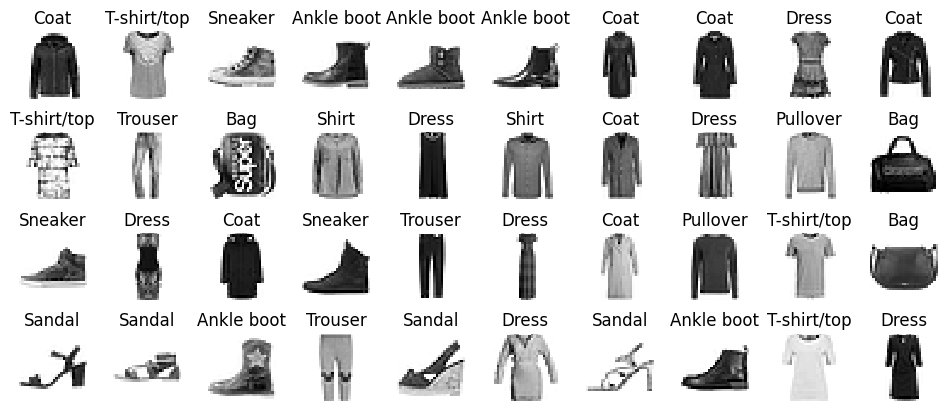

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()



# Build a Model with to try out various learning rates

In [10]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28,28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [13]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

expon_lr = ExponentialLearningRate(factor=1.005)

In [14]:
history = model.fit(x_train, y_train, epochs=1,
          validation_data=(x_valid, y_valid),
                    callbacks=[expon_lr]
                    )

1719/1719 [==============================] - 13s 8ms/step - loss: nan - accuracy: 0.5153 - val_loss: nan - val_accuracy: 0.0914


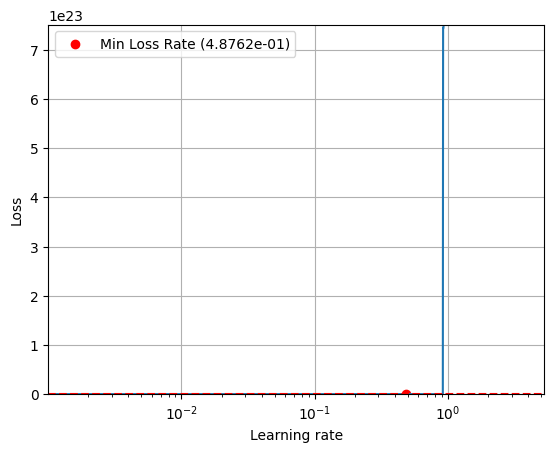

In [15]:
min_loss_rate = expon_lr.rates[expon_lr.losses.index(min(expon_lr.losses))]

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates), colors='r', linestyles='dashed')
plt.scatter(min_loss_rate, min(expon_lr.losses), color='r', marker='o', label=f'Min Loss Rate ({min_loss_rate:.4e})')
plt.axis([min(expon_lr.rates), max(expon_lr.rates), min(expon_lr.losses), max(expon_lr.losses)])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Train new model with the optimal learning rate

In [23]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28,28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)


In [25]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=min_loss_rate),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [26]:
history = model.fit(x_train, y_train, epochs=6,
          validation_data=(x_valid, y_valid)
                    )

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8185 - accuracy: 0.6953 - val_loss: 0.6718 - val_accuracy: 0.7650
Epoch 2/6
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5428 - accuracy: 0.7999 - val_loss: 0.4648 - val_accuracy: 0.8410
Epoch 3/6
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4752 - accuracy: 0.8287 - val_loss: 0.6246 - val_accuracy: 0.7790
Epoch 4/6
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4390 - accuracy: 0.8411 - val_loss: 0.4051 - val_accuracy: 0.8536
Epoch 5/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4184 - accuracy: 0.8492 - val_loss: 0.4472 - val_accuracy: 0.8438
Epoch 6/6
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4016 - accuracy: 0.8550 - val_loss: 0.4147 - val_accuracy: 0.8568


In [28]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 73.7456 - accuracy: 0.8250


[73.74557495117188, 0.824999988079071]

In [29]:
#predict first 3 test data

x_pred = x_test[:10]
y_proba = model.predict(x_pred).round(2)
display(y_proba)

#select the index with the highest probability for each softmax prediction
y_pred = np.argmax(y_proba, axis=1)
y_pred_names = np.array(class_names)[y_pred]

display(y_pred, y_pred_names)

1/1 [==============================] - 0s 74ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

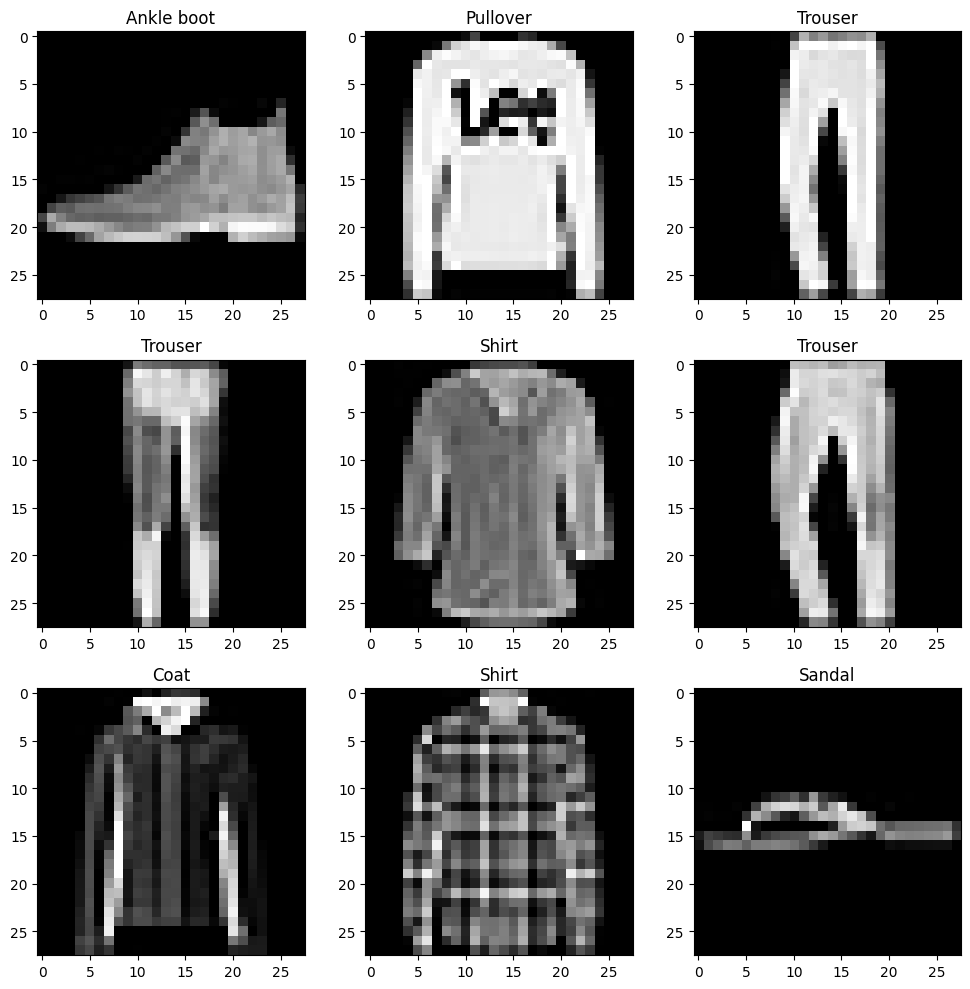

In [30]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

# Iterate through each image and plot it on a subplot
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(x_pred[3*i+j], cmap='gray')
        axes[i, j].set_title(y_pred_names[3*i+j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
